In [1]:
import polars as pl
import numpy as np
from datetime import datetime

import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
ogDF = pl.read_csv('satcat.csv')
df = ogDF.with_columns([
    pl.col("DECAY").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("DECAY"),
    pl.col("LAUNCH").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("LAUNCH")
])
current_date = pl.lit(datetime.now()).cast(pl.Date)
df = df.with_columns([
    (pl.when(pl.col("DECAY").is_not_null())
     .then((pl.col("DECAY") - pl.col("LAUNCH")).cast(pl.Int64) / (1000 * 60 * 60 * 24))
     .otherwise((current_date - pl.col("LAUNCH")).cast(pl.Int64) / (1000 * 60 * 60 * 24)))
    .alias("DECAY_TIME")
])

df = df.filter(
    (df["PERIOD"] != "") &
    (df["INCLINATION"] != "") &
    (df["APOGEE"] != "") &
    (df["PERIGEE"] != "")
)

df = df.with_columns([
    df["PERIOD"].cast(pl.Float64),
    df["INCLINATION"].cast(pl.Float64),
    df["APOGEE"].cast(pl.Float64),
    df["PERIGEE"].cast(pl.Float64)
])


In [3]:
# New DF because I wonder if you can predict what type of object it is based on period, inclination, apogee, and perigee

model = RandomForestClassifier()
modelDF = pl.DataFrame(
    {
        "OBJECT_TYPE": df["OBJECT_TYPE"],
        "PERIOD": df["PERIOD"],
        "INCLINATION": df["INCLINATION"],
        "APOGEE": df["APOGEE"],
        "PERIGEE": df["PERIGEE"]
    }
)

In [4]:
train,test=train_test_split(modelDF,test_size=0.15,random_state=3,stratify=modelDF["OBJECT_TYPE"])
train_X=train.drop("OBJECT_TYPE")
train_Y=train["OBJECT_TYPE"]
test_X=test.drop("OBJECT_TYPE")
test_Y=test["OBJECT_TYPE"]
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print(metrics.classification_report(prediction,test_Y))

              precision    recall  f1-score   support

      DEBRIS       0.93      0.88      0.90      5558
     PAYLOAD       0.81      0.86      0.83      2607
 ROCKET BODY       0.56      0.63      0.59       853
     UNKNOWN       0.42      0.64      0.51        76

    accuracy                           0.85      9094
   macro avg       0.68      0.75      0.71      9094
weighted avg       0.86      0.85      0.85      9094


In [29]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 110, num = 11)]
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 30, num = 4)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 3)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(train_X, train_Y)
print("Successfully found best fit!")


Successfully found best fit!


In [30]:
model = RandomForestClassifier(n_estimators=1560, min_samples_split=11, min_samples_leaf=1, max_features='auto', max_depth=45, bootstrap=True)
model.fit(train_X, train_Y)
prediction = model.predict(test_X)
print(metrics.classification_report(prediction, test_Y))

/Users/db/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

      DEBRIS       0.94      0.88      0.91      5638
     PAYLOAD       0.82      0.87      0.85      2581
 ROCKET BODY       0.56      0.65      0.60       827
     UNKNOWN       0.34      0.83      0.49        48

    accuracy                           0.85      9094
   macro avg       0.66      0.81      0.71      9094
weighted avg       0.87      0.85      0.86      9094


Interestingly, debris and payload look easier to predict than rocket body and unknown. In addition, a hyperparameter tuned model which uses inclination, period, apogee, and perigree as features does not have significant improvement. This may be due to a poorly chosen model or improper method of hyperparameter tuning.


In [5]:
newModelDF = pl.DataFrame(
    {
        "OBJECT_TYPE": df["OBJECT_TYPE"],
        "PERIOD": df["PERIOD"],
        "INCLINATION": df["INCLINATION"],
        "APOGEE": df["APOGEE"],
        "PERIGEE": df["PERIGEE"],
        "DECAY_TIME": df["DECAY_TIME"]
    }
)
train,test=train_test_split(modelDF,test_size=0.15,random_state=3,stratify=modelDF["OBJECT_TYPE"])
train_X=train.drop("OBJECT_TYPE")
train_Y=train["OBJECT_TYPE"]
test_X=test.drop("OBJECT_TYPE")
test_Y=test["OBJECT_TYPE"]
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print(metrics.classification_report(prediction,test_Y))

              precision    recall  f1-score   support

      DEBRIS       0.93      0.88      0.90      5547
     PAYLOAD       0.82      0.86      0.84      2611
 ROCKET BODY       0.56      0.63      0.59       861
     UNKNOWN       0.43      0.67      0.52        75

    accuracy                           0.85      9094
   macro avg       0.68      0.76      0.71      9094
weighted avg       0.86      0.85      0.85      9094


It seems that adding decay time as a feature does not improve the model.

In [7]:
y_pred = prediction
y_true = test_Y

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.85


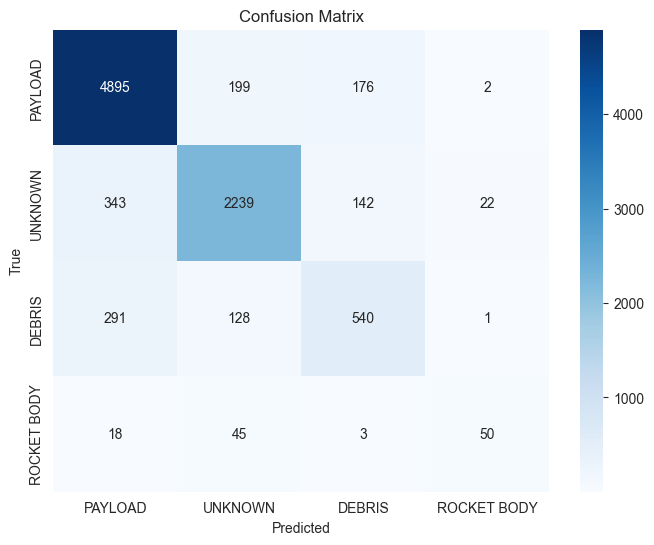

In [8]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modelDF["OBJECT_TYPE"].unique(), yticklabels=modelDF["OBJECT_TYPE"].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Holy moly, is it because the testing set for some categories is too small?

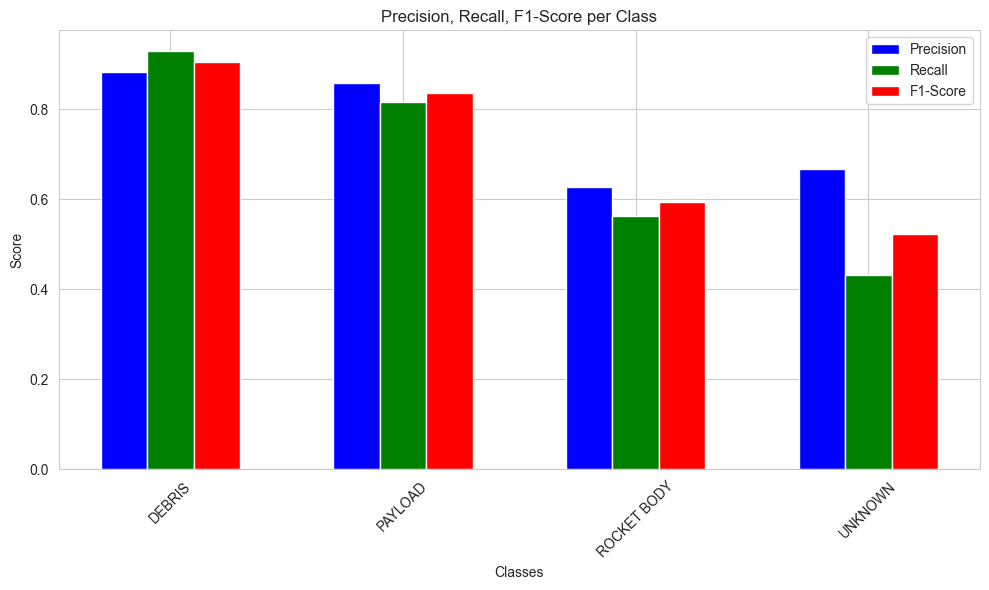

In [10]:
report = classification_report(y_true, y_pred, output_dict=True)

report_data = {
    'class': list(report.keys())[:-3], 
    'precision': [report[class_]['precision'] for class_ in report.keys() if class_ not in ['accuracy', 'macro avg', 'weighted avg']],
    'recall': [report[class_]['recall'] for class_ in report.keys() if class_ not in ['accuracy', 'macro avg', 'weighted avg']],
    'f1-score': [report[class_]['f1-score'] for class_ in report.keys() if class_ not in ['accuracy', 'macro avg', 'weighted avg']]
}

df_report = pl.DataFrame(report_data)

classes = df_report['class'].to_list()
precision = df_report['precision'].to_list()
recall = df_report['recall'].to_list()
f1_score = df_report['f1-score'].to_list()

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2 
x = np.arange(len(classes))

ax.bar(x - width, precision, width, label='Precision', color='b')
ax.bar(x, recall, width, label='Recall', color='g')
ax.bar(x + width, f1_score, width, label='F1-Score', color='r')

ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


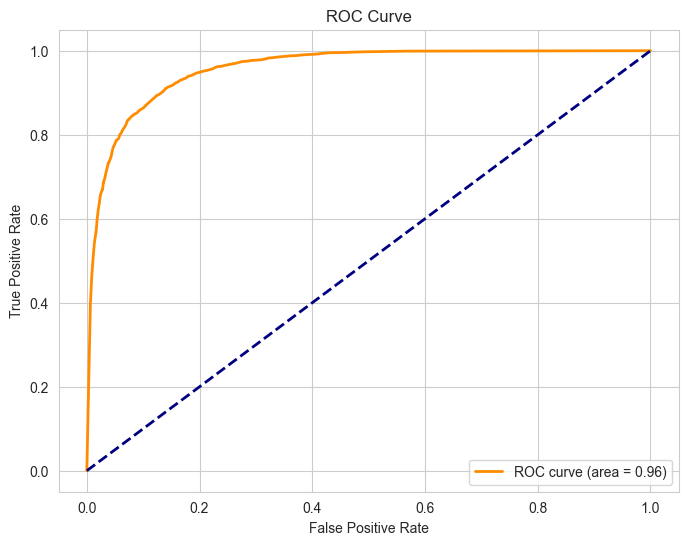

In [14]:
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = model.predict_proba(test_X)

fpr, tpr, _ = roc_curve(y_true_bin[:, 0], y_pred_bin[:, 0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

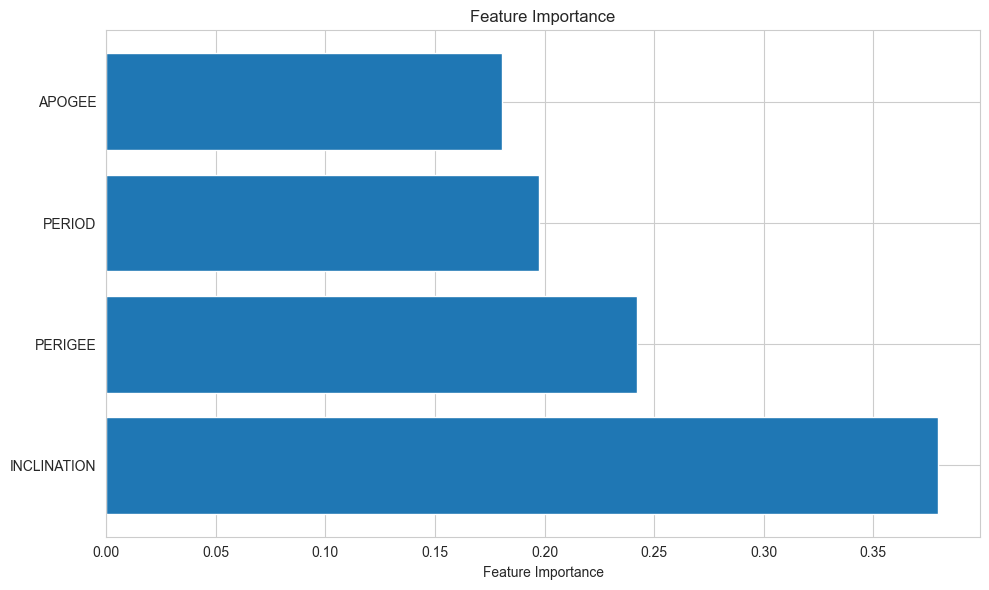

In [15]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [train_X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## Model Findings
Generally, performance could be improved by playing more with the dataset and doing some more feature engineering. It performed well on predicting if items are debris or payload, but not so well on predicting if items are rocket body or unknown. This could be due to the fact that there are fewer rocket bodies and unknowns in the dataset; hence, the model unable to learn the features of these classes well. The model could be improved by using a more complex model, or by using a different set of features.